In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Clone SAM 3 to Google Drive (only needs to be done once)
import os

SAM3_PATH = "/content/drive/MyDrive/sam3"

if not os.path.exists(SAM3_PATH):
    print("Cloning SAM 3 to Google Drive (one-time setup)...")
    !git clone https://github.com/facebookresearch/sam3.git "{SAM3_PATH}"
    print("✅ SAM 3 cloned to Drive!")
else:
    print(f"✓ SAM 3 already exists at: {SAM3_PATH}")

# Install SAM 3 from Drive location
%cd "{SAM3_PATH}"
!pip install -e .
%cd /content

# Install other dependencies, ensuring triton and pillow-heif are installed
!pip install -q pillow-heif triton decord

print("✅ Installation complete!")

✓ SAM 3 already exists at: /content/drive/MyDrive/sam3
/content/drive/MyDrive/sam3
Obtaining file:///content/drive/MyDrive/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 103.0 MB/s eta 0:00:00
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15375 sha256=4340a5f9a37b429efd4aa690a4fd6cb01a60fb2d7d8aef90c966a7651fe1953c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pqgpoqy/wheels/a9/f6/56/8bceed5d64a938729b

/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 144.4 MB/s eta 0:00:00
✅ Installation complete!


In [1]:
# Verify installation
import sys
import torch

# Add SAM 3 from Drive to path
SAM3_PATH = "/content/drive/MyDrive/sam3"
if SAM3_PATH not in sys.path:
    sys.path.insert(0, SAM3_PATH)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Test SAM 3 import from Drive
from sam3 import model_builder
print("✓ SAM 3 imported successfully from Drive!")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
✓ SAM 3 imported successfully from Drive!


In [2]:
# Login to Hugging Face (required for SAM 3)
from huggingface_hub import login

# Get your token from: https://huggingface.co/settings/tokens
# Also accept license at: https://huggingface.co/facebook/sam3
login()

In [5]:
# Configuration - UPDATE THIS PATH!
DRIVE_PATH = "/content/drive/MyDrive/TRAIN"  # <-- Change to your folder path
OUTPUT_DIR = "/content/drive/MyDrive/segmented_output"

# Component classes
COMPONENT_CLASSES = ["seal", "tin", "screw", "hole", "glass"]

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if path exists
if os.path.exists(DRIVE_PATH):
    print(f"✓ Found TRAIN folder at: {DRIVE_PATH}")
    print(f"  Contents: {os.listdir(DRIVE_PATH)}")
else:
    print(f"✗ TRAIN folder not found at: {DRIVE_PATH}")
    print("  Please update DRIVE_PATH variable above")

✓ Found TRAIN folder at: /content/drive/MyDrive/TRAIN
  Contents: ['.DS_Store', 'positive', 'negative']


In [6]:
import torch
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from google.colab.patches import cv2_imshow

# Register HEIC support
pillow_heif.register_heif_opener()

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Load SAM 3 Model

In [7]:
# Load SAM 3 model with LOWER confidence threshold for better recall
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
import importlib

# Enable TF32 for faster computation on Ampere GPUs
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# BPE path from Drive location
SAM3_PATH = "/content/drive/MyDrive/sam3"
bpe_path = f"{SAM3_PATH}/sam3/assets/bpe_simple_vocab_16e6.txt.gz"
print(f"BPE path: {bpe_path}")
print(f"Exists: {os.path.exists(bpe_path)}")

print("Loading SAM 3 model (this may take a few minutes)...")

# Reload the patched modules to ensure changes are picked up
try:
    if 'sam3.model.position_encoding' in sys.modules:
        importlib.reload(sys.modules['sam3.model.position_encoding'])
except Exception as e:
    pass

try:
    if 'sam3.model_builder' in sys.modules:
        importlib.reload(sys.modules['sam3.model_builder'])
except Exception as e:
    pass

model = build_sam3_image_model(bpe_path=bpe_path, device=device)

# LOWER confidence threshold (0.1-0.2) for better recall
# You can adjust this - lower = more detections (but more false positives)
CONFIDENCE_THRESHOLD = 0.15
processor = Sam3Processor(model, confidence_threshold=CONFIDENCE_THRESHOLD)
print(f"✓ SAM 3 loaded with confidence threshold: {CONFIDENCE_THRESHOLD}")

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


BPE path: /content/drive/MyDrive/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz
Exists: True
Loading SAM 3 model (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

✓ SAM 3 loaded with confidence threshold: 0.15


## Option A: Use SAM 3 with Text Prompts (No YOLO training needed)

This uses SAM 3's text understanding to find components directly.
Components: **seal, tin, screw, hole, glass**

In [17]:
import cv2
from PIL import Image

# Ensure HEIC works via PIL (you already registered earlier, but safe here too)
try:
    import pillow_heif
    pillow_heif.register_heif_opener()
except Exception:
    pass

try:
    from ultralytics import YOLO
except Exception as e:
    raise RuntimeError("Ultralytics not installed. Run: !pip install -q ultralytics") from e

# -------- Config (adjust if needed) --------
# Prefer trained weights first (best.pt). Fallback is COCO yolov8n.pt (won't have facade).
YOLO_WEIGHTS_CANDIDATES = [
    "/content/drive/MyDrive/best.pt",
]

# Use your dataset root; expects subfolders like positive/negative (keeps structure)
SOURCE_DIR = globals().get("DRIVE_PATH", "/content/drive/MyDrive/TRAIN")

# Where crops are saved
BASE_OUTPUT_DIR = globals().get("OUTPUT_DIR", "/content/drive/MyDrive/segmented_output")
OUTPUT_DIR_FACADE = os.path.join(BASE_OUTPUT_DIR, "resFacade")

CONFIDENCE_THRESHOLD = 0.25

# Accept these names as "facade"
FACADE_CLASS_ALIASES = {
    "facade", "fascade", "facade_element", "facadeelement", "façade", "fassade"
}

# Optional override: set to an int to force a class id (e.g., 0)
FACADE_CLASS_ID = None  # e.g. 0

# -------- Helpers --------
def _pick_weights(candidates):
    for p in candidates:
        if p and os.path.exists(p):
            return p
    return None

def _pil_to_bgr(pil_img):
    rgb = np.array(pil_img.convert("RGB"))
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

def _read_image_bgr_any(path):
    # Read all formats via PIL (works for HEIC if pillow_heif/pi-heif is installed)
    pil_img = Image.open(path)
    return _pil_to_bgr(pil_img)

def _find_class_ids(names, aliases):
    """
    names can be dict {id: name} or list.
    Returns list of class ids whose lowercased name is in aliases.
    """
    if names is None:
        return []
    if isinstance(names, dict):
        items = names.items()
    else:
        items = enumerate(names)
    out = []
    for i, n in items:
        if str(n).strip().lower() in aliases:
            out.append(int(i))
    return out

def process_images_facade():
    model_path = _pick_weights(YOLO_WEIGHTS_CANDIDATES)
    if not model_path:
        print("Error: No YOLO weights found. Checked:")
        for p in YOLO_WEIGHTS_CANDIDATES:
            print(" -", p)
        return

    print(f"✓ YOLO weights: {model_path}")
    model = YOLO(model_path)
    print("✓ YOLO model loaded")
    print("Model classes:", getattr(model, "names", None))

    os.makedirs(OUTPUT_DIR_FACADE, exist_ok=True)
    print(f"✓ Output dir: {OUTPUT_DIR_FACADE}")

    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".webp", ".heic", ".heif")

    # Determine facade class ids
    if isinstance(FACADE_CLASS_ID, int):
        facade_ids = [FACADE_CLASS_ID]
        print(f"✓ Using manual FACADE_CLASS_ID={FACADE_CLASS_ID}")
    else:
        facade_ids = _find_class_ids(getattr(model, "names", None), FACADE_CLASS_ALIASES)

        # If model is single-class, treat that as facade (common for custom training)
        names = getattr(model, "names", None)
        if not facade_ids and isinstance(names, dict) and len(names) == 1:
            facade_ids = [int(list(names.keys())[0])]
            print(f"✓ Single-class model detected; using class id {facade_ids[0]} as facade")

        if not facade_ids:
            print("⚠️  Facade class not found in model.names; facade-only cropping will SKIP saving.")
            print("   This usually means you loaded a COCO checkpoint (person/car/bench...).")
            print("   Fix: use your trained weights (best.pt) or set FACADE_CLASS_ID.")
            # Still run to show what it detects (prints best detection per image), but won't save crops.

    count_processed = 0
    count_saved = 0
    count_detected_any = 0

    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if not file.lower().endswith(image_extensions):
                continue

            image_path = os.path.join(root, file)

            rel_path = os.path.relpath(root, SOURCE_DIR)
            save_dir = OUTPUT_DIR_FACADE if rel_path == "." else os.path.join(OUTPUT_DIR_FACADE, rel_path)
            os.makedirs(save_dir, exist_ok=True)

            print(f"\nProcessing: {image_path}")
            count_processed += 1

            try:
                img_bgr = _read_image_bgr_any(image_path)
                h, w = img_bgr.shape[:2]

                results = model(img_bgr, verbose=False)

                best_box = None
                best_conf = -1.0
                best_cls = None

                for r in results:
                    boxes = getattr(r, "boxes", None)
                    if boxes is None:
                        continue

                    for box in boxes:
                        conf = float(box.conf[0])
                        cls_id = int(box.cls[0])

                        # Only consider facade classes (if known)
                        if facade_ids and cls_id not in facade_ids:
                            continue

                        if conf >= CONFIDENCE_THRESHOLD and conf > best_conf:
                            best_conf = conf
                            best_box = box
                            best_cls = cls_id

                # If no facade ids known, still print top detection (debug), but do not save
                if best_box is None and not facade_ids:
                    # Print best overall (any class) to help you debug weights
                    best_any = None
                    best_any_conf = -1.0
                    best_any_cls = None
                    for r in results:
                        boxes = getattr(r, "boxes", None)
                        if boxes is None:
                            continue
                        for box in boxes:
                            conf = float(box.conf[0])
                            cls_id = int(box.cls[0])
                            if conf > best_any_conf:
                                best_any_conf = conf
                                best_any = box
                                best_any_cls = cls_id

                    if best_any is not None:
                        cls_name = model.names.get(best_any_cls, str(best_any_cls)) if isinstance(model.names, dict) else str(best_any_cls)
                        xyxy = best_any.xyxy[0].cpu().numpy().tolist()
                        print(f"  Detected (non-facade) best: {cls_name} conf={best_any_conf:.3f} box={xyxy}")
                        count_detected_any += 1
                    else:
                        print("  No detections.")
                    continue

                if best_box is None:
                    print("  No facade detected.")
                    continue

                count_detected_any += 1

                x1, y1, x2, y2 = best_box.xyxy[0].cpu().numpy()
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # Clamp
                x1 = max(0, x1); y1 = max(0, y1)
                x2 = min(w, x2); y2 = min(h, y2)

                crop = img_bgr[y1:y2, x1:x2]
                if crop.size == 0:
                    print("  Skipped: empty crop after clamping.")
                    continue

                cls_name = model.names.get(best_cls, str(best_cls)) if isinstance(model.names, dict) else str(best_cls)

                # Always save as .jpg (cv2 can't reliably write HEIC)
                base = os.path.splitext(file)[0]
                save_name = f"{base}_{cls_name}.jpg"
                save_path = os.path.join(save_dir, save_name)

                ok = cv2.imwrite(save_path, crop)
                if ok:
                    count_saved += 1
                    print(f"  Saved best facade crop ({cls_name}) -> {save_path} (Conf: {best_conf:.2f})")
                else:
                    print(f"  Failed to write: {save_path}")

            except Exception as e:
                print(f"  Error: {e}")

    print("\nDone!")
    print(f"Processed: {count_processed}")
    print(f"Images with detections (any): {count_detected_any}")
    print(f"Facade crops saved: {count_saved}")
    print(f"Saved to: {OUTPUT_DIR_FACADE}")

# Run now (comment out if you only want the function defined)
process_images_facade()

✓ YOLO weights: /content/drive/MyDrive/best.pt
✓ YOLO model loaded
Model classes: {0: 'facade', 1: 'objects'}
✓ Output dir: /content/drive/MyDrive/segmented_output/resFacade

Processing: /content/drive/MyDrive/TRAIN/positive/IMG_5700.HEIC
  Saved best facade crop (facade) -> /content/drive/MyDrive/segmented_output/resFacade/positive/IMG_5700_facade.jpg (Conf: 0.84)

Processing: /content/drive/MyDrive/TRAIN/positive/IMG_5653.HEIC
  Saved best facade crop (facade) -> /content/drive/MyDrive/segmented_output/resFacade/positive/IMG_5653_facade.jpg (Conf: 0.98)

Processing: /content/drive/MyDrive/TRAIN/positive/IMG_5659.HEIC
  Saved best facade crop (facade) -> /content/drive/MyDrive/segmented_output/resFacade/positive/IMG_5659_facade.jpg (Conf: 0.94)

Processing: /content/drive/MyDrive/TRAIN/positive/IMG_5701.HEIC
  Saved best facade crop (facade) -> /content/drive/MyDrive/segmented_output/resFacade/positive/IMG_5701_facade.jpg (Conf: 0.96)

Processing: /content/drive/MyDrive/TRAIN/positive

In [13]:
def load_image(image_path):
    """Load image (supports HEIC, JPG, PNG)"""
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None


def segment_with_text_prompt(pil_image, text_prompt):
    """Segment using SAM 3 text prompt - CORRECTED API usage"""
    try:
        # Step 1: Set the image first
        inference_state = processor.set_image(pil_image)

        # Step 2: Set text prompt - this RETURNS the output!
        output = processor.set_text_prompt(
            state=inference_state,
            prompt=text_prompt
        )

        # Extract results from the OUTPUT (not inference_state)
        masks = output.get("masks", None)
        boxes = output.get("boxes", None)
        scores = output.get("scores", None)

        # Convert tensors to lists for easier handling
        if masks is not None and len(masks) > 0:
            return masks, boxes, scores
        return None, None, None

    except Exception as e:
        print(f"    Error with prompt '{text_prompt}': {e}")
        return None, None, None


def segment_with_multiple_prompts(pil_image, prompts_list, min_score=0.1):
    """Try multiple prompt variations and combine best results"""
    all_masks = []
    all_boxes = []
    all_scores = []
    all_prompts = []

    for prompt in prompts_list:
        masks, boxes, scores = segment_with_text_prompt(pil_image, prompt)

        if masks is not None and len(masks) > 0:
            # Filter by minimum score
            if scores is not None:
                for i in range(len(masks)):
                    score = scores[i].item() if hasattr(scores[i], 'item') else float(scores[i])
                    if score >= min_score:
                        all_masks.append(masks[i])
                        all_boxes.append(boxes[i] if boxes is not None else None)
                        all_scores.append(score)
                        all_prompts.append(prompt)
            else:
                # No scores, keep all
                for i in range(len(masks)):
                    all_masks.append(masks[i])
                    all_boxes.append(boxes[i] if boxes is not None else None)
                    all_scores.append(1.0)
                    all_prompts.append(prompt)

    return all_masks, all_boxes, all_scores, all_prompts


def process_image_with_text(image_path, output_path):
    """Process single image using text prompts for each component"""
    print(f"\nProcessing: {os.path.basename(image_path)}")

    # Load image
    pil_image = load_image(image_path)
    if pil_image is None:
        return None

    # Use LARGER image for better detection
    max_dim = 1536
    w, h = pil_image.size
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        pil_image = pil_image.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
        print(f"  Resized to {pil_image.size}")

    # Convert for visualization
    image_np = np.array(pil_image)
    annotated = image_np.copy()

    all_results = {}

    # Define colors for each component
    component_colors = {
        "seal": (0, 0, 0),        # Red
        "tin": (0, 255, 0),       # Green
        "screw": (0, 0, 255),     # Blue
        "hole": (255, 255, 0),    # Yellow
        "glass": (255, 0, 255)    # Magenta
    }

    total_detections = 0

    # Segment each component type using MULTIPLE prompts
    for component, prompts in COMPONENT_PROMPTS.items():
        print(f"  Detecting: {component} (trying {len(prompts)} prompts)...", end=" ")

        masks, boxes, scores, used_prompts = segment_with_multiple_prompts(
            pil_image, prompts, min_score=0.1
        )

        if masks and len(masks) > 0:
            print(f"Found {len(masks)} (prompts: {set(used_prompts)})")
            total_detections += len(masks)

            all_results[component] = {
                'masks': masks,
                'boxes': boxes,
                'scores': scores
            }

            color = component_colors.get(component, (128, 128, 128))

            # Draw masks
            for i, mask in enumerate(masks):
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy()
                else:
                    mask_np = np.array(mask)

                mask_bool = mask_np.astype(bool)
                if mask_bool.ndim > 2:
                    mask_bool = mask_bool.squeeze()

                # Apply color overlay
                annotated[mask_bool] = (annotated[mask_bool] * 0.5 + np.array(color) * 0.5).astype(np.uint8)

                # Draw contour
                contours, _ = cv2.findContours(
                    mask_bool.astype(np.uint8),
                    cv2.RETR_EXTERNAL,
                    cv2.CHAIN_APPROX_SIMPLE
                )
                cv2.drawContours(annotated, contours, -1, color, 2)

                # Add label with score at centroid
                if len(contours) > 0:
                    M = cv2.moments(contours[0])
                    if M["m00"] > 0:
                        cx = int(M["m10"] / M["m00"])
                        cy = int(M["m01"] / M["m00"])
                        label = f"{component}:{scores[i]:.2f}" if scores else component
                        cv2.putText(annotated, label, (cx-30, cy),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
                        cv2.putText(annotated, label, (cx-30, cy),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        else:
            print("None found")

    print(f"  TOTAL detections: {total_detections}")

    # Save result
    annotated_bgr = cv2.cvtColor(annotated.astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, annotated_bgr)
    print(f"  Saved: {output_path}")

    return all_results, annotated

In [14]:
COMPONENT_PROMPTS = {
    "seal": [
        "seal",
        "rubber seal",
        "black rubber seal",
        "gasket",
        "rubber gasket",
        "weatherstrip",
        "weather stripping",
        "window weatherstripping",
        "rubber strip",
        "thin rubber strip",
        "thin black strip",
        "black border around glass",
        "dark rubber line around the pane",
        "window gasket",
        "glazing gasket",
        "frame gasket",
        "EPDM gasket",
        "silicone gasket",
        "sealant bead",
        "rubber edging",
        "edge seal",
        "rubber seal around the glass",
        "black rubber strip around window",
        "gasket between glass and frame",
        "seal around window perimeter",
        "seal on window frame edge",
        "rubber seal in the groove",
        "seal between metal and glass",
    ],
    "tin": ["tin", "metal tin", "metal sheet", "metal casing", "aluminum"],
    "screw": ["screw", "small screw", "screw head", "fastener", "bolt"],
    "hole": ["hole", "circular hole", "opening", "perforation", "vent"],
    "glass": ["glass", "window glass", "transparent pane", "glass panel", "refractive surface"],
}

print("✓ COMPONENT_PROMPTS defined:")
for component, prompts in COMPONENT_PROMPTS.items():
    print(f"  - {component}: {len(prompts)} prompts")

✓ COMPONENT_PROMPTS defined:
  - seal: 28 prompts
  - tin: 5 prompts
  - screw: 5 prompts
  - hole: 5 prompts
  - glass: 5 prompts


Testing with: /content/drive/MyDrive/segmented_output/resFacade/positive/IMG_5700_facade.jpg
Original size: 5391x2034
Resized to: (1536, 579)

=== TESTING INDIVIDUAL PROMPTS ===

Prompt: 'glass'
  ✗ No detections

Prompt: 'window'
  ✗ No detections

Prompt: 'metal'
  ✓ Found 84 detection(s)
    Detection 1: score=0.193
    Detection 2: score=0.219
    Detection 3: score=0.363
    Detection 4: score=0.250
    Detection 5: score=0.199
    Detection 6: score=0.216
    Detection 7: score=0.180
    Detection 8: score=0.171
    Detection 9: score=0.471
    Detection 10: score=0.201
    Detection 11: score=0.211
    Detection 12: score=0.226
    Detection 13: score=0.201
    Detection 14: score=0.258
    Detection 15: score=0.247
    Detection 16: score=0.190
    Detection 17: score=0.187
    Detection 18: score=0.160
    Detection 19: score=0.156
    Detection 20: score=0.270
    Detection 21: score=0.414
    Detection 22: score=0.176
    Detection 23: score=0.266
    Detection 24: score=0.1

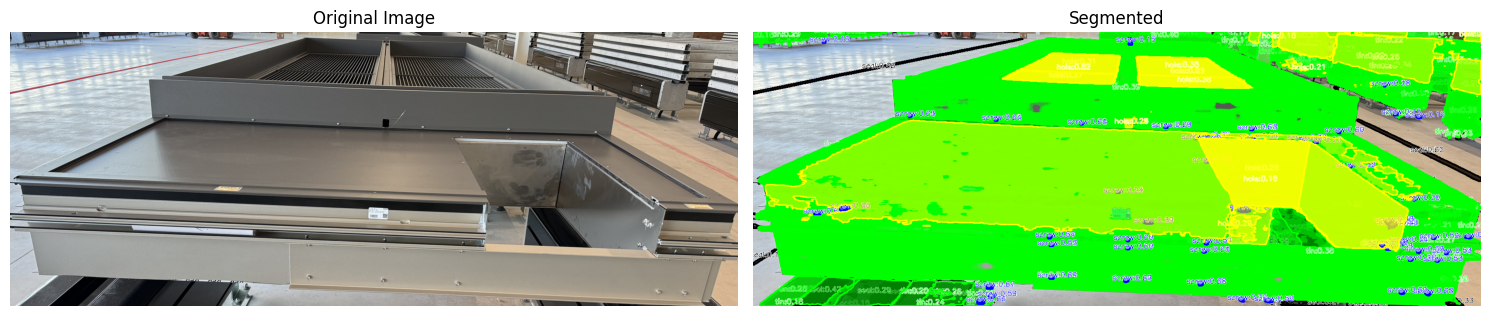

In [21]:
# === TEST ON SINGLE IMAGE WITH VERBOSE OUTPUT ===
import matplotlib.pyplot as plt
from PIL import Image

# Pick first image from positive folder (including HEIC)
test_folder = "/content/drive/MyDrive/segmented_output/resFacade/positive"
test_images = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.heic', '.heif'))]

if test_images:
    test_image_path = os.path.join(test_folder, test_images[0])
    print(f"Testing with: {test_image_path}")

    # Load and resize
    test_img = load_image(test_image_path)
    if test_img:
        w, h = test_img.size
        print(f"Original size: {w}x{h}")

        # Resize if needed
        max_dim = 1536
        if max(h, w) > max_dim:
            scale = max_dim / max(h, w)
            test_img = test_img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
            print(f"Resized to: {test_img.size}")

        # Show original image
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(test_img)
        plt.title("Original Image")
        plt.axis('off')

        # Test with verbose debug for each prompt type
        print("\n=== TESTING INDIVIDUAL PROMPTS ===")

        # Simple prompts first
        test_prompts = [
            "glass",
            "window",
            "metal",
            "rubber",
            "screw",
            "hole",
            "seal",
            "black rubber seal on window frame",
            "metal sheet cladding",
            "small screw head",
        ]

        for prompt in test_prompts:
            print(f"\nPrompt: '{prompt}'")
            masks, boxes, scores = segment_with_text_prompt(test_img, prompt)

            if masks is not None and len(masks) > 0:
                print(f"  \u2713 Found {len(masks)} detection(s)")
                if scores is not None:
                    for i, s in enumerate(scores):
                        score_val = s.item() if hasattr(s, 'item') else float(s)
                        print(f"    Detection {i+1}: score={score_val:.3f}")
            else:
                print(f"  \u2717 No detections")

        # Process and show result
        output_path = f"{OUTPUT_DIR}/test_debug.jpg"
        results, annotated = process_image_with_text(test_image_path, output_path)

        plt.subplot(1, 2, 2)
        plt.imshow(annotated)
        plt.title("Segmented")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print("No test images found!")

## Process All Images

In [26]:
def process_folder(folder_path, output_folder):
    """Process all images in a folder"""
    os.makedirs(output_folder, exist_ok=True)

    extensions = ('.jpg', '.jpeg', '.png', '.heic', '.heif')
    images = [f for f in os.listdir(folder_path)
              if f.lower().endswith(extensions) and not f.startswith('.')]

    print(f"\n{'='*50}")
    print(f"Processing {len(images)} images from {folder_path}")
    print(f"{'='*50}")

    for i, img_file in enumerate(images):
        print(f"\n[{i+1}/{len(images)}]", end=" ")

        input_path = os.path.join(folder_path, img_file)
        base_name = os.path.splitext(img_file)[0].replace(" ", "_")
        output_path = os.path.join(output_folder, f"{base_name}_segmented.jpg")

        try:
            process_image_with_text(input_path, output_path)
        except Exception as e:
            print(f"  Error: {e}")

    print(f"\n{'='*50}")
    print(f"Done! Results saved to: {output_folder}")

In [ ]:
# Process positive folder
positive_path = "/content/drive/MyDrive/segmented_output/resFacade/positive"
if os.path.exists(positive_path):
    process_folder(positive_path, os.path.join(OUTPUT_DIR, "positive"))
else:
    print(f"Positive folder not found: {positive_path}")


Processing 12 images from /content/drive/MyDrive/TRAIN/positive

[1/12] 
Processing: IMG_5675.HEIC
  Resized to (1536, 1152)
  Detecting: seal (trying 5 prompts)... Found 1 (prompts: {'rubber'})
  Detecting: tin (trying 4 prompts)... Found 88 (prompts: {'orange metal', 'metal casing', 'aluminum'})
  Detecting: screw (trying 5 prompts)... Found 116 (prompts: {'screw', 'screw head', 'bolt', 'fastener', 'small screw'})
  Detecting: hole (trying 2 prompts)... Found 53 (prompts: {'small hole', 'circular hole'})
  Detecting: glass (trying 5 prompts)... Found 45 (prompts: {'glass panel', 'glass', 'transparent pane', 'window glass'})
  TOTAL detections: 303
  Saved: /content/drive/MyDrive/segmented_output/positive/IMG_5675_segmented.jpg

[2/12] 
Processing: IMG_5658.HEIC
  Resized to (1536, 1152)
  Detecting: seal (trying 5 prompts)... Found 2 (prompts: {'black rubber'})
  Detecting: tin (trying 4 prompts)... Found 32 (prompts: {'orange metal', 'metal casing', 'aluminum'})
  Detecting: screw 

In [ ]:
# Process negative folder
negative_path = "/content/drive/MyDrive/segmented_output/resFacade/negative"
if os.path.exists(negative_path):
    process_folder(negative_path, os.path.join(OUTPUT_DIR, "negative"))
else:
    print(f"Negative folder not found: {negative_path}")


Processing 43 images from /content/drive/MyDrive/segmented_output/resFacade/negative

[1/43] 
Processing: IMG_5491 3_facade.jpg
  Resized to (1536, 1122)
  Detecting: seal (trying 28 prompts)... 

## Done! 🎉

Your segmented images are saved in Google Drive at:
`/content/drive/MyDrive/segmented_output/`